In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

## Load model and predict

In [2]:
! ls ../pkl/*ada*.pkl

../pkl/13_model_tuning_ada_models_df.pkl
../pkl/13_model_tuning_ada_models_dwnsampled_3.pkl
../pkl/13_model_tuning_ada_models_dwnsampled_5.pkl
../pkl/13_model_tuning_ada_models_inner_unbalanced.pkl
../pkl/13_model_tuning_ada_models_inner_upsampled_3.pkl
../pkl/13_model_tuning_ada_models_unbalanced.pkl
../pkl/13_model_tuning_ada_models_upsampled_3.pkl
../pkl/13_model_tuning_ada_models_upsampled_5.pkl
../pkl/13_model_tuning_Xtest_ada_inner_unbalanced.pkl
../pkl/13_model_tuning_Xtrain_ada_inner_unbalanced.pkl
../pkl/13_model_tuning_Ypred_test_ada_inner_unbalanced.pkl
../pkl/13_model_tuning_Ypred_train_ada_inner_unbalanced.pkl
../pkl/13_model_tuning_Ytest_ada_inner_unbalanced.pkl
../pkl/13_model_tuning_Ytrain_ada_inner_unbalanced.pkl


In [4]:
fwf = pd.read_pickle('../pkl/10_class_balancing_fwf.pkl')

Ytrain = pd.read_pickle('../pkl/13_model_tuning_Ytrain_ada_inner_unbalanced.pkl')
Xtrain = pd.read_pickle('../pkl/13_model_tuning_Xtrain_ada_inner_unbalanced.pkl')

Ytest = pd.read_pickle('../pkl/13_model_tuning_Ytest_ada_inner_unbalanced.pkl')
Xtest = pd.read_pickle('../pkl/13_model_tuning_Xtest_ada_inner_unbalanced.pkl')

Ypred_test = pd.read_pickle('../pkl/13_model_tuning_Ypred_test_ada_inner_unbalanced.pkl')
Ypred_train = pd.read_pickle('../pkl/13_model_tuning_Ypred_train_ada_inner_unbalanced.pkl')

ada = pd.read_pickle('../pkl/13_model_tuning_ada_models_unbalanced.pkl')

# feat_cols = [x for x in features.columns if x not in ['date','location']]

In [5]:
print Ytrain.shape, Xtrain.shape, Ytest.shape, Xtest.shape, Ypred_test.shape, Ypred_train.shape, fwf.shape

(800,) (800, 26) (343,) (343, 26) (343, 1) (800, 1) (1605, 5)


In [6]:
Ytrain.index.max(), Ytest.index.max(), fwf.index.max()

(1728, 1703, 1604)

In [7]:
fwf.head(1)

,location,cases_first_date,cases_total,date,zika_bool
0,Argentina-Buenos_Aires,130,3028,2016-03-19,1


In [8]:
(np.in1d(Ytrain.index,Xtrain.index).all(), 
 np.in1d(Ytest.index,Xtest.index).all(), 
 np.invert(np.in1d(Ytrain.index,fwf.index)).sum())

(True, True, 62)

In [173]:
print Xtest.shape, Ytest.shape

test = pd.merge(Xtest, Ytest.to_frame(), left_index=True, right_index=True)
test = pd.merge(test, Ypred_test.rename(columns={'zika_bool':'zika_pred'}), 
                left_index=True, right_index=True)
test = pd.merge(test, fwf[['location','date','cases_first_date','cases_total']], on=['location','date'], how='left')

print test.shape

(343, 26) (343,)
(343, 30)


In [180]:
print Xtrain.shape, Ytrain.shape

train = pd.merge(Xtrain, Ytrain.to_frame(), left_index=True, right_index=True)
train = pd.merge(train, Ypred_train.rename(columns={'zika_bool':'zika_pred'}), 
                left_index=True, right_index=True)
train = pd.merge(train, fwf[['location','date','cases_first_date','cases_total']], on=['location','date'], how='left')

print train.shape

(800, 26) (800,)
(800, 30)


In [181]:
data = pd.concat([test, train]).reset_index(drop=True)

In [182]:
data['cm_type'] = np.NaN

mask0 = (data.zika_bool.astype(bool) & data.zika_pred.astype(bool))
data.loc[mask0, 'cm_type'] = 0

mask1 = (data.zika_bool.astype(bool) & data.zika_pred.astype(bool).pipe(np.invert))
data.loc[mask1, 'cm_type'] = 1

mask2 = (data.zika_bool.astype(bool).pipe(np.invert) & data.zika_pred.astype(bool))
data.loc[mask2, 'cm_type'] = 3

mask3 = (data.zika_bool.astype(bool).pipe(np.invert) & data.zika_pred.astype(bool).pipe(np.invert))
data.loc[mask3, 'cm_type'] = 2

data['cm_type'] = data.cm_type.astype(np.int)

In [185]:
confusion_matrix(data['zika_bool'], data['zika_pred'])

array([[107,  87],
       [ 19, 930]])

In [186]:
data.cm_type.value_counts().sort_index()

0    930
1     19
2    107
3     87
Name: cm_type, dtype: int64

## Get location coordinates

In [259]:
location_key_orig = pd.read_pickle('../pkl/00_cleaned_city_names.pkl')
location_key = pd.read_pickle('../pkl/01_latitude_longitude_google.pkl')

# cases = pd.read_pickle('../pkl/10_class_balancing_framework_a_first.pkl')
cases = pd.read_pickle('../pkl/03_infection_data_final.pkl')

print cases.shape

cases = cases[['date','location','zika_cases']].groupby(['location','date']).sum().reset_index()

print cases.shape

(103630, 4)
(33405, 3)


In [260]:
cases.head()

,location,date,zika_cases
0,Argentina-Buenos_Aires,2016-03-19,130
1,Argentina-Buenos_Aires,2016-03-26,148
2,Argentina-Buenos_Aires,2016-04-02,176
3,Argentina-Buenos_Aires,2016-04-09,181
4,Argentina-Buenos_Aires,2016-04-16,186


In [261]:
def join_names(df_row):

    subtype = df_row.location_type
    
    second_str = df_row[subtype]
    country_str = df_row.country
    
    return pd.Series({'country':country_str, 'city':second_str, 
                      'location':df_row.location})

In [262]:
location_key_orig = location_key_orig.apply(join_names, axis=1)

In [326]:
print location_key_orig.shape, location_key.shape, cases.shape

combined = pd.merge(location_key_orig.drop_duplicates(), location_key, on='location', how='left')

print combined.shape

combined = pd.merge(data[['location','date','zika_bool','zika_pred','cm_type']], 
                    combined, on='location', how='left')

print combined.shape

combined = pd.merge(cases, combined.drop(['date'],axis=1), on=['location'], how='right')

combined['zika_bool']

print combined.shape

(1606, 3) (1606, 3) (33405, 3)
(1606, 5)
(1271, 9)
(24781, 10)


In [327]:
combined.isnull().sum()

location      0
date          0
zika_cases    0
zika_bool     0
zika_pred     0
cm_type       0
city          0
country       0
latitude      0
longitude     0
dtype: int64

In [328]:
(combined[['location','country','date','zika_cases']]
 .groupby('country')
 .sum()
  .sort_values('zika_cases',ascending=False))

,zika_cases
country,
Dominican Republic,2077578
Colombia,1212238
Brazil,1030867
El Salvador,35368
Argentina,21293
United States,10668
Guatemala,5188
Mexico,4709
Ecuador,1267


In [329]:
mask = combined.country.isin(['Dominican Republic', 'Colombia'])
combined.loc[mask, 'zika_cases'] /= 10

In [330]:
tmp = combined.sort_values('zika_cases',ascending=False).head(1000)
tmp.cm_type.value_counts()

0    1000
Name: cm_type, dtype: int64

In [331]:
combined.rename(columns={'cm_type':'color'},inplace=True)

combined['zika_cases'] = (combined.zika_cases * 99./combined.zika_cases.max()) + 1
combined['location'] = combined.location.str.replace('-','_')

combined = (combined
 .sort_values('date')
 
 .rename(columns={'country':'state','location':'permalink',
                  'latitude':'lat', 'longitude':'long',
                  'date':'created_at'})
 [['city','state','permalink','created_at','lat','long','zika_cases','color']]
 .assign(permalink=combined.location + combined.date.dt.strftime("_%Y%m%d")))

In [332]:
# mask = (combined.state=='United States') & (combined.color==0)
tmp = combined[['city','state','lat','long']].drop_duplicates()

city        Peðol
state    Colombia
lat       34.5398
long     -80.9116
Name: 2748, dtype: object


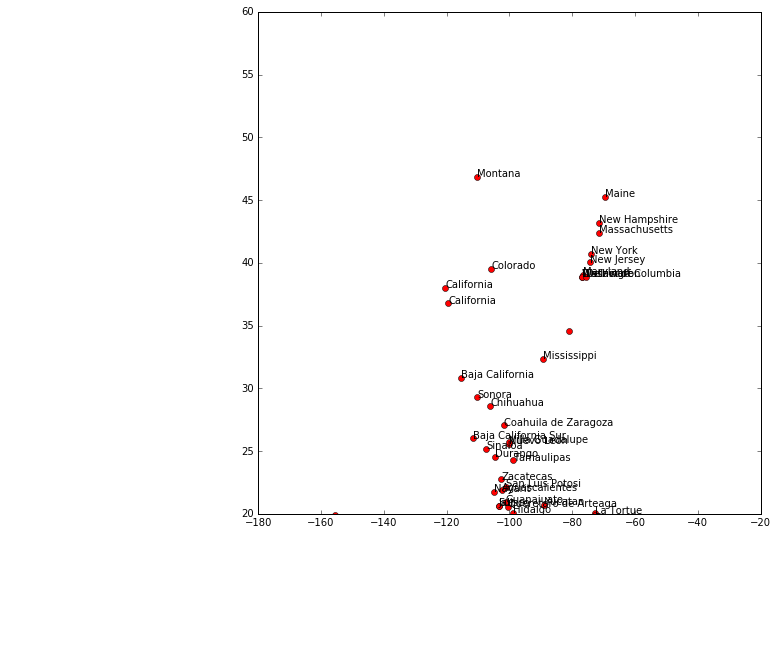

In [320]:
f = plt.figure()
ax = plt.axes()
f.set_size_inches(9,9)

ax.plot(tmp.long,tmp.lat,'ro')
ax = plt.axes()
ax.set_ylim(20,60)
for idx,dat in tmp.iterrows():
    try:
        ax.annotate(dat.city,xy=(dat.long,dat.lat),textcoords='data')
    except:
        print dat

In [334]:
mask = ((combined.state=='Colombia') & combined.city.str.startswith('Pe')).pipe(np.invert)
combined = combined.loc[mask]

In [335]:
(combined.to_csv('../map/zika_places.csv', 
            sep=',', 
            index=False, 
            date_format='%Y-%m-%d %H:%M:%S'))
! head ../map/zika_places.csv

city,state,permalink,created_at,lat,long,zika_cases,color
Morazan,El Salvador,El_Salvador_Morazan_20151128,2015-11-28 00:00:00,13.7682,-88.1291,1.0085365065,0
San Luis Potosi,Mexico,Mexico_San_Luis_Potosi_20151128,2015-11-28 00:00:00,22.1565,-100.9855,1.0,2
Coahuila de Zaragoza,Mexico,Mexico_Coahuila_de_Zaragoza_20151128,2015-11-28 00:00:00,27.0587,-101.7068,1.0,0
Quintana Roo,Mexico,Mexico_Quintana_Roo_20151128,2015-11-28 00:00:00,19.1817,-88.4791,1.0,1
San Miguel,El Salvador,El_Salvador_San_Miguel_20151128,2015-11-28 00:00:00,13.4793,-88.1779,1.034146026,0
Guanajuato,Mexico,Mexico_Guanajuato_20151128,2015-11-28 00:00:00,20.917,-101.1617,1.0,3
Yucatan,Mexico,Mexico_Yucatan_20151128,2015-11-28 00:00:00,20.7099,-89.0943,1.0,0
Morelos,Mexico,Mexico_Morelos_20151128,2015-11-28 00:00:00,18.6813,-99.1013,1.0,3
La Libertad,El Salvador,El_Salvador_La_Libertad_20151128,2015-11-28 00:00:00,13.4907,-89.3085,1.13231585074,0


In [275]:
combined.sort_values('zika_cases',ascending=False)[['city','state','created_at','zika_cases']].head(100)

,city,state,created_at,zika_cases
762,Rio de Janeiro,Brazil,2016-05-28,100.000000
426,Bahia,Brazil,2016-05-28,99.913376
761,Rio de Janeiro,Brazil,2016-05-21,94.680006
425,Bahia,Brazil,2016-05-21,93.232748
424,Bahia,Brazil,2016-05-14,89.345223
423,Bahia,Brazil,2016-05-07,89.258599
422,Bahia,Brazil,2016-04-30,83.849869
760,Rio de Janeiro,Brazil,2016-05-14,83.448440
759,Rio de Janeiro,Brazil,2016-05-07,83.412522
421,Bahia,Brazil,2016-04-23,76.807955
